# Model: RNN (Recurrent Natural Network)  - Stock Token: ITD - Test/Train/Vaildation: 80/10/10
- Dataset: 1313 rows x 7 column (01/03/2019 - 01/06/2024)
- Window-slide: 10, epochs: 200, batch-size: 32
----
### Model evaluation (Test set)
- RMSE: 277.7379756506306
- MAE: 206.45443522135417
- MAPE: 1.9344025642520504 %

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Input

## 1. Data preprocessing


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Change stock and split to adjust between splitting type and stock
stock = 2  # ITD
split = 2  # 8 1 1

In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")

df = df[["time", "close"]]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

df.head()

,close
time,
2019-03-01,6900
2019-03-04,7100
2019-03-05,7100
2019-03-06,7170
2019-03-07,7170


In [5]:
df.shape

(1313, 1)

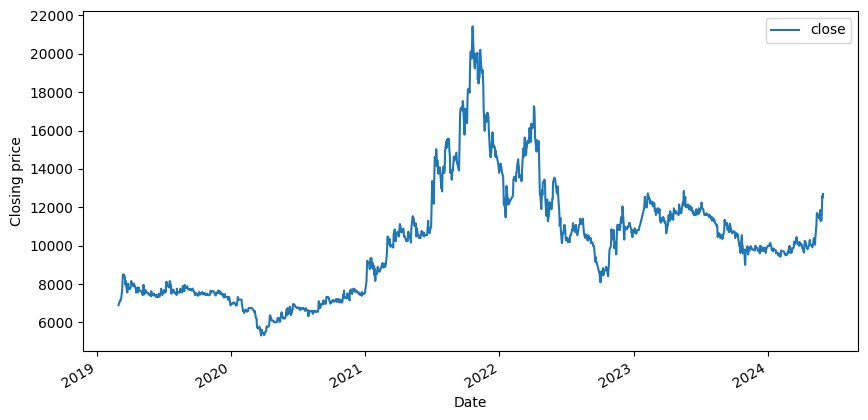

In [6]:
df.plot(figsize=(10, 5))
plt.ylabel("Closing price")
plt.xlabel("Date")
plt.show()

In [7]:
df = df.reset_index()["close"]
df

0        6900
1        7100
2        7100
3        7170
4        7170
        ...  
1308    11300
1309    12050
1310    12600
1311    12500
1312    12700
Name: close, Length: 1313, dtype: int64

In [8]:
# Normalize data between 0 and 1 because we using natural network model
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

## 2. Model training


### Create train set, test set, validation set and reshape them

In [9]:
# Defining the split size
train_size = int(split_type[split][0] * len(df_scaled))
test_size = int(split_type[split][1] * len(df_scaled))
val_size = len(df) - train_size - test_size

In [10]:
# Splitting data into train, test and validation set
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size : train_size + test_size]
val_data = df_scaled[train_size + test_size :]

In [11]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_side):
    X, y = [], []

    for i in range(len(data) - window_side - 1):
        X.append(data[i : (i + window_side), 0])
        y.append(data[i + window_side, 0])

    return np.array(X), np.array(y)

In [12]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SIDE = 10

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SIDE)
X_val, y_val = create_dataset(val_data, WINDOW_SIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1039, 10), (1039,), (120, 10), (120,), (121, 10), (121,))

In [13]:
# Reshape the dataset to suit the RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

### Start train model


In [14]:
# Initialize RNN:
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        SimpleRNN(100),
        Dense(1),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the RNN
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mean_absolute_error"],
)

In [16]:
EPOCHS = 200
BATCH_SIZE = 32
VERBOSE = 1

# Fit model with the train dataset
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0151 - mean_absolute_error: 0.0866 - val_loss: 4.5933e-04 - val_mean_absolute_error: 0.0182
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0230 - val_loss: 3.1292e-04 - val_mean_absolute_error: 0.0141
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1118e-04 - mean_absolute_error: 0.0196 - val_loss: 3.0066e-04 - val_mean_absolute_error: 0.0136
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1836e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0018 - val_mean_absolute_error: 0.0398
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7443e-04 - mean_absolute_error: 0.0216 - val_loss: 2.3300e-04 - val_mean_absolute_error: 0.0111
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4142e-04 - mean_absolute_error: 0.0163 - val_loss: 2.6392e-04 - val_mean_absolute_error: 0.0126
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3926e

### Predicting with test set and validate set

In [17]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

y_pred_val = model.predict(X_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


## 3. Model evaluation


In [18]:
# Splitting data into train, test and validation set again to evaluate, because i shaped the data between 0 and 1 to suit the model
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]
val_data1 = df[train_size + test_size :]

X_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

X_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [19]:
print(len(y_test))
print(len(y_test1))

120
131


In [20]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)

def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f'MSE: {mse(y, y_pred)}')
    print(f'RMSE: {np.sqrt(mse(y, y_pred))}')
    print(f'MAE: {mae(y, y_pred)}')
    print(f'MAPE: {mape(y, y_pred) * 100} %')

In [21]:
# So the result will change every time RUN ALL (build model again), because the model will take random start number.
# But it dont change much, the MAPE will 1.47% ~ 1.8% (test set)
# Model evaluation on test set
print("Model evalution on test set")
evalute_model(y_test1, y_pred_test)

print("")
# Model evaluation on validate set
print("Model evalution on validate set")
evalute_model(y_val1, y_pred_val)

Model evalution on test set
MSE: 77138.38311851025
RMSE: 277.7379756506306
MAE: 206.45443522135417
MAPE: 1.9344025642520504 %

Model evalution on validate set
MSE: 79085.98764652063
RMSE: 281.22231000850667
MAE: 194.1319489282025
MAPE: 1.863969330354949 %


## 4. Predict the next 30/60/90 days


In [22]:
def forecast(data, window_side, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_side:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_side, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [23]:
y_pred_30_days = forecast(val_data, 5, 30)

# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

In [24]:
y_pred_30_days

array([[13042.776],
       [12962.789],
       [13067.583],
       [13027.459],
       [13080.643],
       [13059.817],
       [13076.2  ],
       [13067.833],
       [13074.663],
       [13070.992],
       [13073.511],
       [13072.053],
       [13073.059],
       [13072.456],
       [13072.85 ],
       [13072.609],
       [13072.765],
       [13072.667],
       [13072.73 ],
       [13072.692],
       [13072.717],
       [13072.701],
       [13072.71 ],
       [13072.704],
       [13072.708],
       [13072.706],
       [13072.708],
       [13072.705],
       [13072.707],
       [13072.707],
       [13072.708]], dtype=float32)

### Continute predict the next 60/90 days

In [25]:
y_pred_60_days = forecast(val_data, 5, 60)
y_pred_60_days = np.array(y_pred_60_days).reshape(-1, 1)
y_pred_60_days = scaler.inverse_transform(y_pred_60_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [26]:
y_pred_90_days = forecast(val_data, 5, 90)
y_pred_90_days = np.array(y_pred_90_days).reshape(-1, 1)
y_pred_90_days = scaler.inverse_transform(y_pred_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

### Plotting the data

In [27]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")
    plt.plot(val_data1.index, val_data1, label="Validate")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SIDE : len(y_pred_test) + WINDOW_SIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred_test,
        label="Predicted Test",
        linestyle="--",
    )
    plt.plot(
        val_data1.index[WINDOW_SIDE : len(y_pred_val) + WINDOW_SIDE],
        y_pred_val,
        label="Predicted Validate",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        val_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Predicted Next {days} Days",
        linestyle="--",
    )

    plt.title(f"{stock_name[stock]} Stock Closing Price Prediction Using RNN")
    plt.legend()
    plt.show()

### Predict the closing price next 30/60/90 days

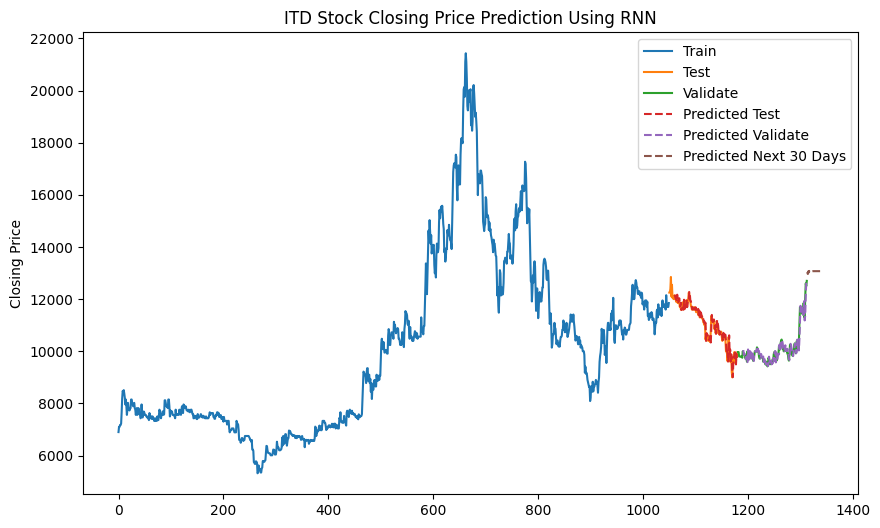

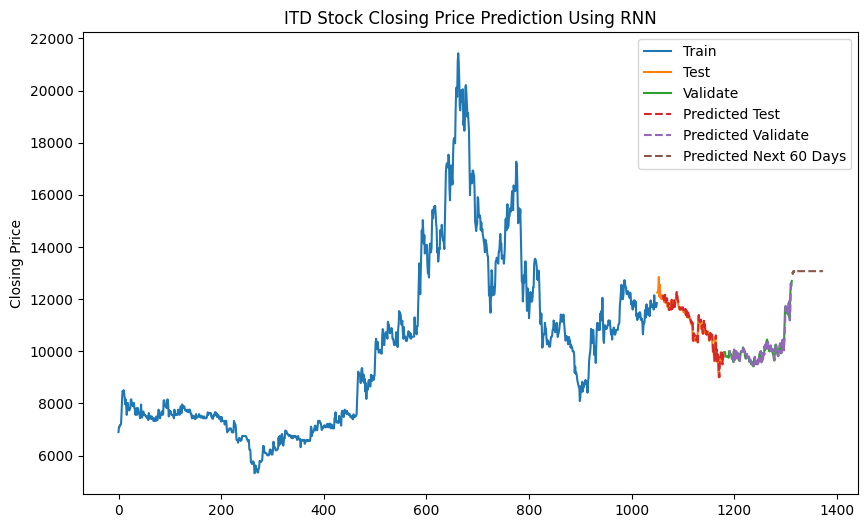

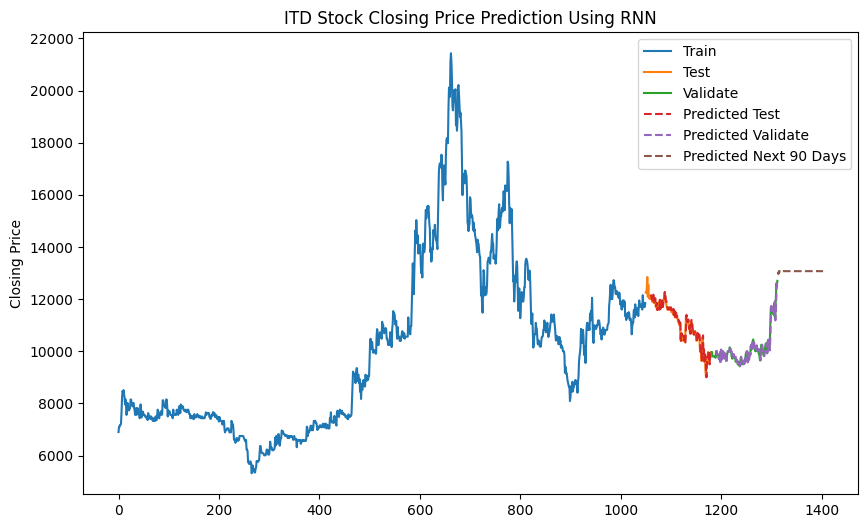

In [28]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)